In [1]:
import torch
torch.cuda.is_available()

True

## This training code does not need yolov7 to obtain keypoints

## Create custom dataloader

In [4]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import torch
import time
from torch.utils.data import Dataset, DataLoader


from torchvision import transforms
from PIL import Image


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


transform = transforms.Compose([
    # Convert frames to PyTorch tensors
    transforms.ToTensor(), 
    # Resize all video frames to 480, 640 (480p)
    transforms.Resize((480,640), antialias=True), 
    # Convert to grayscale
    transforms.Grayscale(num_output_channels=1), 
])

class VideoDataset(Dataset):
    def __init__(self, video_files, video_folder, transform=transform):
        self.video_folder = video_folder
        self.video_files = video_files
        self.transform = transform
        self.data = self._load_data()
    
    def _load_data(self):
        data = []
        count = 5
        
        for video_file in self.video_files:
            video_path = os.path.join(self.video_folder, video_file)
            # if the video name is "nofixxx.mp4", this means no-fight --> 0
            # if "NV_xx.mp4" means no-fight
            if "nofi" in video_file or "NV" in video_file:
                label = 0
            else:
                label = 1
                
            # Check if we extract the labels correctly
            # if count >= 0:
            #     print(f'video path: {video_path}')
            #     print(f'label: {label}')
            #     count -= 1
                                      
            capture = cv2.VideoCapture(video_path)
            fps = int(capture.get(cv2.CAP_PROP_FPS))
            total_frames = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
             
            for idx in range(0, total_frames, fps): # Sample one frame per second
                capture.set(cv2.CAP_PROP_POS_FRAMES, idx)
                ret, frame = capture.read()
                if ret:
                    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    data.append((frame_rgb, label))
            capture.release()
        return data
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        pose_image, label = self.data[idx]
        if self.transform:
            pose_image = self.transform(pose_image)
            
            # Check the outputs given by yolov7 output witih the added transformations
            
            # Convert the tensor to a numpy array and squeeze the first dimension
            # pose_image_np = pose_image.numpy().squeeze()
            # pose_image = pose_image.repeat(3, 1, 1)

            # count = 3
            # if count >= 0:
            #     plt.figure(figsize=(30, 7))
            #     plt.axis("off")
            #     plt.imshow(pose_image_np, cmap='gray') # Use cmap for greyscale images
            #     plt.savefig(f"output_without_yolov7{count}.jpg") # Save output if needed
            #     count -= 1
                    
        return pose_image, label


## Prepare video paths and labels

In [79]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

print("Preparing dataloaders...")

video_folder = "../fight-detection-4"
video_files = [f for f in os.listdir(video_folder) if f.endswith((".mp4", ".avi", ".mov", ".mpeg"))]


print("Splitting data...")
# Split dataset such that 20% of data is used for testing, remaining 80% for training + validation
train_files, test_files = train_test_split(video_files, test_size=0.2, random_state=42)
# Split dataset such that 60% of data is used for training, remaining 20% for validation
train_files, val_files = train_test_split(train_files, test_size=0.25, random_state=42) # 0.25 * 0.8 = 0.2


train_dataset = VideoDataset(train_files, video_folder)
print("Train dataset compiled...")
val_dataset = VideoDataset(val_files, video_folder)
print("Validation dataset compiled...")
test_dataset = VideoDataset(test_files, video_folder)
print("Test dataset compiled...")

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
print("Train dataloader compiled...")
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
print("Validation dataloader compiled...")
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print("Test dataloader compiled...")



Preparing dataloaders...
Splitting data...
Train dataset compiled...
Validation dataset compiled...
Test dataset compiled...
Train dataloader compiled...
Validation dataloader compiled...
Test dataloader compiled...


## Create pytorch instance of ResNet

In [5]:
import torch
import torch.nn as nn
from torchvision import models
import torch.optim as optim


# Load a pre-trained ResNet model
model_resnet = models.resnet50(pretrained=True)

# Modify the final layer for binary classification
# --> we apply sigmoid activation during the forward pass or within the loss function
model_resnet.fc = torch.nn.Linear(model_resnet.fc.in_features, 1)


# Freeze the base model parameters
for param in model_resnet.parameters():
    param.requires_grad = False

# Unfreeze the classifier layer parameters
for param in model_resnet.fc.parameters():
    param.requires_grad = True


model_resnet.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Finetune ResNet to train on fighting and non-fighting datasets

In [80]:
# Load the weights from previous epochs
model_resnet.load_state_dict(torch.load('../model_epoch_recent_resnet_without_yolo_data3.pth'))

<All keys matched successfully>

In [81]:
def validate(model, val_loader):
    # Set the model to evaluation mode
    model.eval()  
    val_loss = 0.0
    correct, total = 0, 0
    # Ensure the same loss function is used
    criterion = nn.BCEWithLogitsLoss()  

    # Disable gradient computation
    with torch.no_grad():  
        for pose_img, labels in val_loader:
            # Duplicate the grayscale channel to create a 3-channel image
            pose_img = pose_img.repeat(1, 3, 1, 1) 
            pose_img, labels = pose_img.to(device), labels.to(device).float()
            outputs = model(pose_img)
            
            # Accumulate the loss
            loss = criterion(outputs, labels.unsqueeze(1))
            val_loss += loss.item() * pose_img.size(0)  
            
            # Calculate accuracy
            predicted = torch.round(torch.sigmoid(outputs))
            total += labels.size(0)
            correct += (predicted.cpu() == labels.cpu().unsqueeze(1)).sum().item()

    # Compute the average loss
    val_loss /= len(val_loader.dataset)  
    val_accuracy = correct / total
    return val_loss, val_accuracy

num_epochs = 100

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


# Define loss function and optimiser
criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss
optimizer = torch.optim.Adam(model_resnet.fc.parameters(), lr=0.0001)

# count = 1


for epoch in range(num_epochs):
    model_resnet.train()
    
    running_loss = 0.0
    correct = 0
    total = 0

    for pose_img, labels in train_loader:
        # Duplicate the grayscale channel to create a 3-channel image
        pose_img = pose_img.repeat(1, 3, 1, 1) 
        inputs, labels = pose_img.to(device), labels.to(device).float()

        optimizer.zero_grad()
        outputs = model_resnet(inputs)
        loss = criterion(outputs, labels.unsqueeze(1).float())
        loss.backward()
        
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        predicted = torch.round(torch.sigmoid(outputs))
        total += labels.size(0)
        correct += (predicted.cpu() == labels.cpu().unsqueeze(1)).sum().item()
        
        # if count >= 0:
        #     print(f"Predicted value: {predicted.cpu()}")
        #     print(f"Label: {labels.cpu().unsqueeze(1)}")
        #     count -= 1

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Validation step 
    val_loss, val_accuracy = validate(model_resnet, val_loader)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    
    # Save model weights for every 5 epochs
    # if epoch % 5 == 0:
    #     torch.save(model_resnet.state_dict(), f'../model_epoch_3_{epoch+1}.pth')

Epoch [1/100], Loss: 0.1702
Epoch [2/100], Loss: 0.2943
Epoch [3/100], Loss: 0.2687
Epoch [4/100], Loss: 0.1723
Epoch [5/100], Loss: 0.2530
Epoch [6/100], Loss: 0.3974
Epoch [7/100], Loss: 0.4433
Epoch [8/100], Loss: 0.1514
Epoch [9/100], Loss: 0.3770
Epoch [10/100], Loss: 0.4707
Epoch [11/100], Loss: 0.2688
Epoch [12/100], Loss: 0.4484
Epoch [13/100], Loss: 0.9394
Epoch [14/100], Loss: 0.2843
Epoch [15/100], Loss: 0.2517
Epoch [16/100], Loss: 0.7160
Epoch [17/100], Loss: 0.1143
Epoch [18/100], Loss: 0.5092
Epoch [19/100], Loss: 0.1008
Epoch [20/100], Loss: 0.3365
Epoch [21/100], Loss: 0.1644
Epoch [22/100], Loss: 0.1132
Epoch [23/100], Loss: 0.7188
Epoch [24/100], Loss: 0.0655
Epoch [25/100], Loss: 0.2654
Epoch [26/100], Loss: 0.1280
Epoch [27/100], Loss: 0.2323
Epoch [28/100], Loss: 0.3561
Epoch [29/100], Loss: 0.3519
Epoch [30/100], Loss: 0.3316
Epoch [31/100], Loss: 0.1460
Epoch [32/100], Loss: 0.3392
Epoch [33/100], Loss: 0.0802
Epoch [34/100], Loss: 0.0420
Epoch [35/100], Loss: 0

## Save model weights

In [82]:
torch.save(model_resnet.state_dict(), f'../model_epoch_recent_resnet_without_yolo_data4.pth')

## Show training-val loss and accuracy over epochs

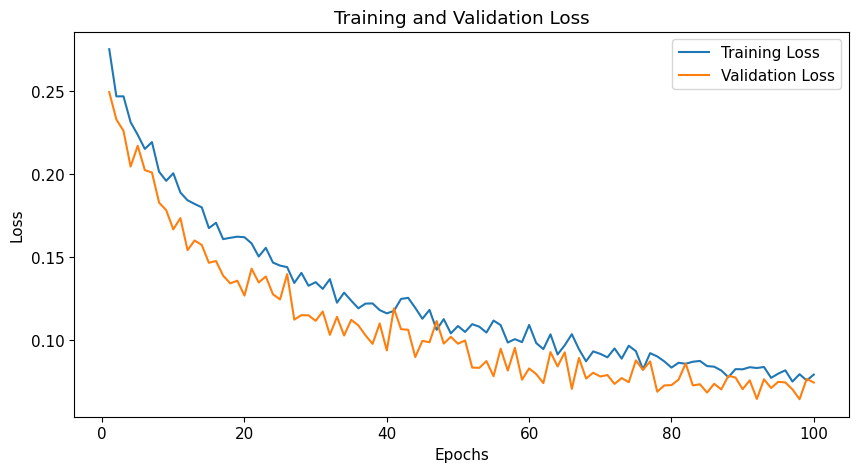

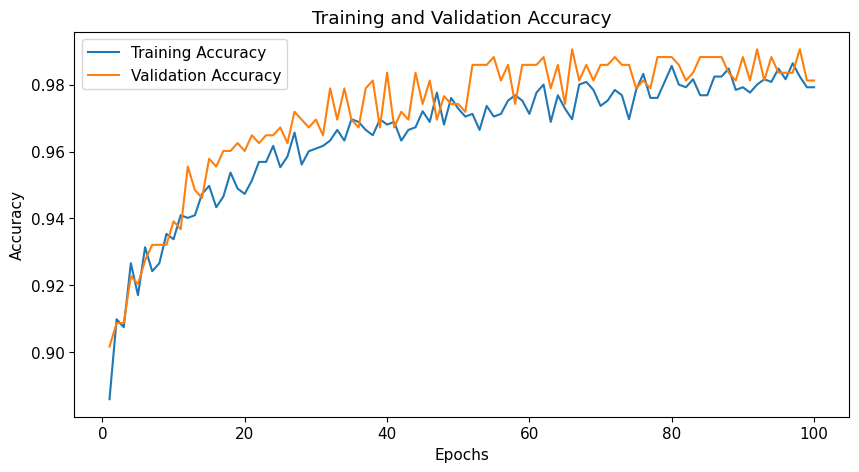

In [ ]:
%matplotlib inline

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()


## Basic inference and testing

In [ ]:
# Load weights
model_resnet.load_state_dict(torch.load('../model_epoch_recent_resnet_without_yolo_data3.pth'))
model_resnet.eval()

###############################################################################

# Pre-process input --> extract frames
video_path = '../fight-detection-2/nofi096.mp4'

###############################################################################

class Video(Dataset):
    def __init__(self, video_path, transform=transform):
        self.video_path = video_path
        self.transform = transform
        self.data = self._load_data()

    def _load_data(self):
        data = []
                                      
        capture = cv2.VideoCapture(self.video_path)
        fps = int(capture.get(cv2.CAP_PROP_FPS))
        total_frames = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))

        # for idx in range(0, total_frames, fps): # use this to sample one frame per second
        for idx in range(0, total_frames, fps): # use this to sample all frames in the video
            capture.set(cv2.CAP_PROP_POS_FRAMES, idx)
            ret, frame = capture.read()
            if ret:
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                keypoints, image = infer(frame_rgb)
                pose_image = draw_keypoints(keypoints, image, return_kpts=False)
                data.append(pose_image)
        capture.release()
        return data
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        pose_image = self.data[idx]
        if self.transform:
            pose_image = self.transform(pose_image)
        return pose_image

###############################################################################
    
processed_video = Video(video_path)
print("Video compiled...")

video_loader = DataLoader(processed_video, batch_size=32, shuffle=True)     
print("Video loaded...")
        
# Inference
for pose_img in video_loader:
    # Duplicate the grayscale channel to create a 3-channel image
    pose_img = pose_img.repeat(1, 3, 1, 1) 
    pose_img = pose_img.to(device)
    outputs = model_resnet(pose_img)
    predicted = torch.round(torch.sigmoid(outputs))
    print(f"Predicted result for batch: {predicted}")

## Testloader
- can be used for unseen dataset
- or for the 20% split dataset done earlier

In [12]:
from sklearn.metrics import f1_score


# Load weights
model_resnet.load_state_dict(torch.load('./model_epoch_recent_resnet_without_yolo_data4.pth'))
model_resnet.eval()

###############################################################################

# Use the Dataloader for unseen dataset - comment out this portion otherwise
print("Preparing a new test dataloader...")

video_folder = "./fight-detection-5"
video_files = [f for f in os.listdir(video_folder) if f.endswith((".mp4", ".avi", ".mov", ".mpeg"))]

test_dataset = VideoDataset(video_files, video_folder)
print("Test dataset compiled...")

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print("Test dataloader compiled...")

###############################################################################

def test(model, test_loader=test_loader):
    test_loss = 0.0
    correct, total = 0, 0
    
    all_labels = []
    all_predictions = []
    
    # Ensure the same loss function is used
    criterion = nn.BCEWithLogitsLoss()  

    # Disable gradient computation
    with torch.no_grad():  
        for pose_img, labels in test_loader:
            # Duplicate the grayscale channel to create a 3-channel image
            pose_img = pose_img.repeat(1, 3, 1, 1) 
            pose_img, labels = pose_img.to(device), labels.to(device).float()
            outputs = model(pose_img)
            
            # Accumulate the loss
            loss = criterion(outputs, labels.unsqueeze(1))
            test_loss += loss.item() * pose_img.size(0)  
            
            # Calculate accuracy
            predicted = torch.round(torch.sigmoid(outputs))
            total += labels.size(0)
            correct += (predicted.cpu() == labels.cpu().unsqueeze(1)).sum().item()
            
            # Collate lables and predictions into numpy for f1 score
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Compute the average loss
    test_loss /= len(test_loader.dataset)  
    test_accuracy = correct / total
    test_f1_score = f1_score(all_labels, all_predictions)
    return test_loss, test_accuracy, test_f1_score

test_loss, test_accuracy, test_f1_score = test(model_resnet)
print(f"Test loss: {test_loss} Test accuracy: {test_accuracy} F1 score: {test_f1_score}")

Preparing a new test dataloader...


[h264 @ 0x829a8d80] mb_type 104 in P slice too large at 98 31
[h264 @ 0x829a8d80] error while decoding MB 98 31
[h264 @ 0x829a8d80] mb_type 104 in P slice too large at 98 31
[h264 @ 0x829a8d80] error while decoding MB 98 31


Test dataset compiled...
Test dataloader compiled...
Test loss: 0.4842783442536312 Test accuracy: 0.7696245733788396 F1 score: 0.7719594594594595


In [85]:
!nvidia-smi

Mon Apr 21 07:13:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Quadro P6000                   Off |   00000000:00:05.0 Off |                    0 |
| 26%   37C    P8              9W /  250W |    3261MiB /  23040MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----